In [1]:
import jax, numpyro
import jax.numpy as jnp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

from tensorflow.keras.models import load_model
from jax.experimental import jax2tf
from jax import random
from numpyro.infer import MCMC, NUTS, Predictive
from numpyro.distributions import (
    Normal, Beta, ImproperUniform, Uniform, Pareto, TruncatedNormal, Categorical, MixtureSameFamily,
    OrderedLogistic, LogNormal
)
from corner import corner

numpyro.set_platform("cpu")
numpyro.set_host_device_count(10)
rng = random.PRNGKey(0)

In [2]:
path = "/mnt/data-storage/stellar-emulator/train/20230628-155230/best_model.tf"
tf_emulator = load_model(path)
# emulator = jax2tf.call_tf(tf_emulator)  # Too slow, due to normalization layer?

In [3]:
weights = tf_emulator.get_weights()
offset = np.array(tf_emulator.layers[-1].offset)
scale = np.array(tf_emulator.layers[-1].scale)

def emulator(x):
    x -= weights[0]
    x /= weights[1]**0.5
    for w, b in zip(weights[3:-2:2], weights[4:-1:2]):
        x = jax.nn.elu(jnp.matmul(x, w) + b)
    x = jnp.matmul(x, weights[-2]) + weights[-1]
    return offset + scale * x

In [4]:
log_zx_sun = np.log10(0.0181)
log_teff_sun = np.log10(5772)

In [5]:
from numpyro.distributions.util import promote_shapes
from numpyro.distributions import Distribution, constraints
from jax import lax

In [6]:
class Salpeter(Distribution):
    arg_constraints = {
        "alpha": constraints.positive,
        "low": constraints.positive,
        "high": constraints.positive
    }
    reparametrized_params = ["alpha", "low", "high"]

    def __init__(self, alpha, *, low=0.1, high=float("inf"), validate_args=None):
        batch_shape = lax.broadcast_shapes(
            jnp.shape(alpha),
            jnp.shape(low),
            jnp.shape(high),
        )
        self.alpha, self.low, self.high = promote_shapes(alpha, low, high)
        self.beta = 1 - self.alpha
        super().__init__(batch_shape, validate_args=validate_args)

    @constraints.dependent_property
    def support(self):
        return constraints.interval(self.low, self.high)

    @property
    def _norm(self):
        return (self.high**self.beta - self.low**self.beta) / self.beta

    def log_prob(self, value):
        log_m = jnp.log(self._norm)
        log_p = - self.alpha * jnp.log(value)
        return jnp.where((value <= self.high) & (value > self.low), log_p - log_m, -jnp.inf)

    def cdf(self, value):
        return (value**self.beta - self.low**self.beta) / self.beta / self._norm
    
    def icdf(self, u):
        return (self.beta * self._norm * u + self.low**self.beta)**(1/self.beta)
    
    def sample(self, key, sample_shape=()):
        shape = sample_shape + self.batch_shape
        minval = jnp.finfo(jnp.result_type(float)).tiny
        u = random.uniform(key, shape, minval=minval)
        return self.icdf(u)

In [43]:
def log_luminosity(log_teff, log_radius):
    return 2 * log_radius + 4 * (log_teff - log_teff_sun)

def hydrogen(log_z, y):
    return 1 - y - 10**log_z

def metallicity(log_z, y):    
    return log_z - jnp.log10(hydrogen(log_z, y)) - log_zx_sun

def model(num_stars, lum=None, teff=None, mh=None,
          sigma_lum=0.01, sigma_teff=50.0, sigma_mh=0.05):
    
    dydz = numpyro.sample("dYdZ", Normal(1.5, 0.5))
    yp = numpyro.sample("Y_p", Normal(0.24, 0.01))
    sigma_y = numpyro.sample("sigma_Y", LogNormal(jnp.log(0.01), 0.3))
    
    with numpyro.plate("star", num_stars):
        eep = numpyro.sample("EEP", Uniform(0., 4.))
        mass = numpyro.sample("mass", Salpeter(2.35, low=0.7, high=2.2))
        log_z = numpyro.sample("log_Z", Uniform(-2.5, -1.5))
        z = numpyro.deterministic("Z", 10**log_z)
        mu_y = yp + dydz * z
        scaled_y = numpyro.sample("scaled_Y", Normal())
        y = numpyro.deterministic("Y", mu_y + sigma_y * scaled_y)
        a_mlt = numpyro.sample("a_MLT", Uniform(1.5, 2.5))

        xx = jnp.stack([eep, mass, y, log_z, a_mlt], axis=-1)
        yy = emulator(xx)

        log_lum = log_luminosity(yy[:, 1], yy[:, 2])
        _lum = 10**log_lum
        _teff = 10**yy[:, 1]
        _mh = metallicity(log_z, y)

        numpyro.sample("lum", Normal(_lum, sigma_lum), obs=lum)
        numpyro.sample("Teff", Normal(_teff, sigma_teff), obs=teff)
        numpyro.sample("[M/H]", Normal(_mh, sigma_mh), obs=mh)

        log_age = numpyro.deterministic("log_age", yy[:, 0])
        age = numpyro.deterministic("age", 10**log_age)
        rad = numpyro.deterministic("rad", 10**yy[:, 2])

In [44]:
true_params = {
    "dYdZ": 1.5,
    "Yp": 0.24,
    "sigma_Y": 0.005,
}

In [45]:
# num_stars = 100

# rng, key = random.split(rng)
# true_model = numpyro.handlers.substitute(
#     numpyro.handlers.seed(model, key), 
#     data=true_params,
# )
# true_trace = numpyro.handlers.trace(true_model).get_trace(num_stars)

In [46]:
num_stars = 10

rng, key = random.split(rng)
true_model = numpyro.handlers.substitute(
    model,
    data=true_params,
)
true_predictive = Predictive(true_model, num_samples=1, batch_ndims=0)
true_stars = true_predictive(key, num_stars)

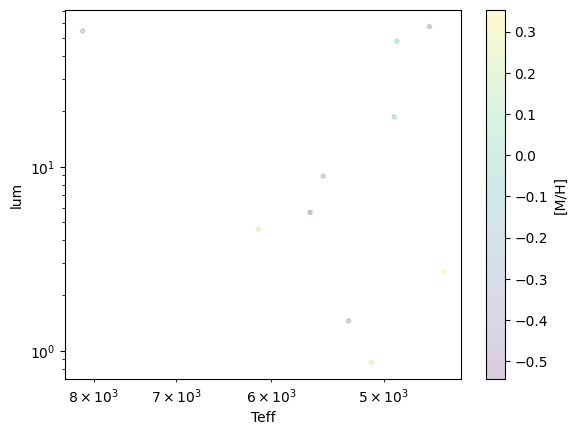

In [47]:
fig, ax = plt.subplots()
xkey = "Teff"
ykey = "lum"
ckey = "[M/H]"

s = ax.scatter(true_stars[xkey], true_stars[ykey], 
           c=true_stars[ckey], marker=".", alpha=0.2)
ax.set_yscale("log")
ax.set_xscale("log")
ax.invert_xaxis()
ax.set_xlabel(xkey)
ax.set_ylabel(ykey)
fig.colorbar(s, label=ckey);

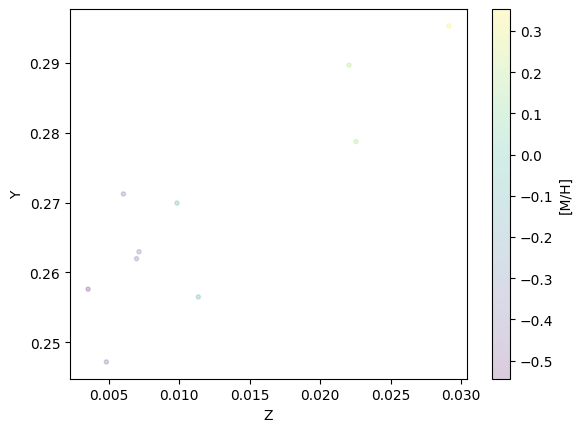

In [48]:
fig, ax = plt.subplots()
xkey = "Z"
ykey = "Y"
ckey = "[M/H]"

s = ax.scatter(true_stars[xkey], true_stars[ykey], 
           c=true_stars[ckey], marker=".", alpha=0.2)

ax.set_xlabel(xkey)
ax.set_ylabel(ykey)
fig.colorbar(s, label=ckey);

In [49]:
rng, key = random.split(rng)
prior_predictive = Predictive(model, num_samples=1000)
prior_samples = prior_predictive(key, num_stars)

In [50]:
coords = {"star": np.arange(num_stars)}
dims = {k: ["star"] for k, v in prior_samples.items() if v.ndim == 2}
data = az.from_numpyro(prior=prior_samples, coords=coords, dims=dims)
data

Inference data with groups:
	> prior

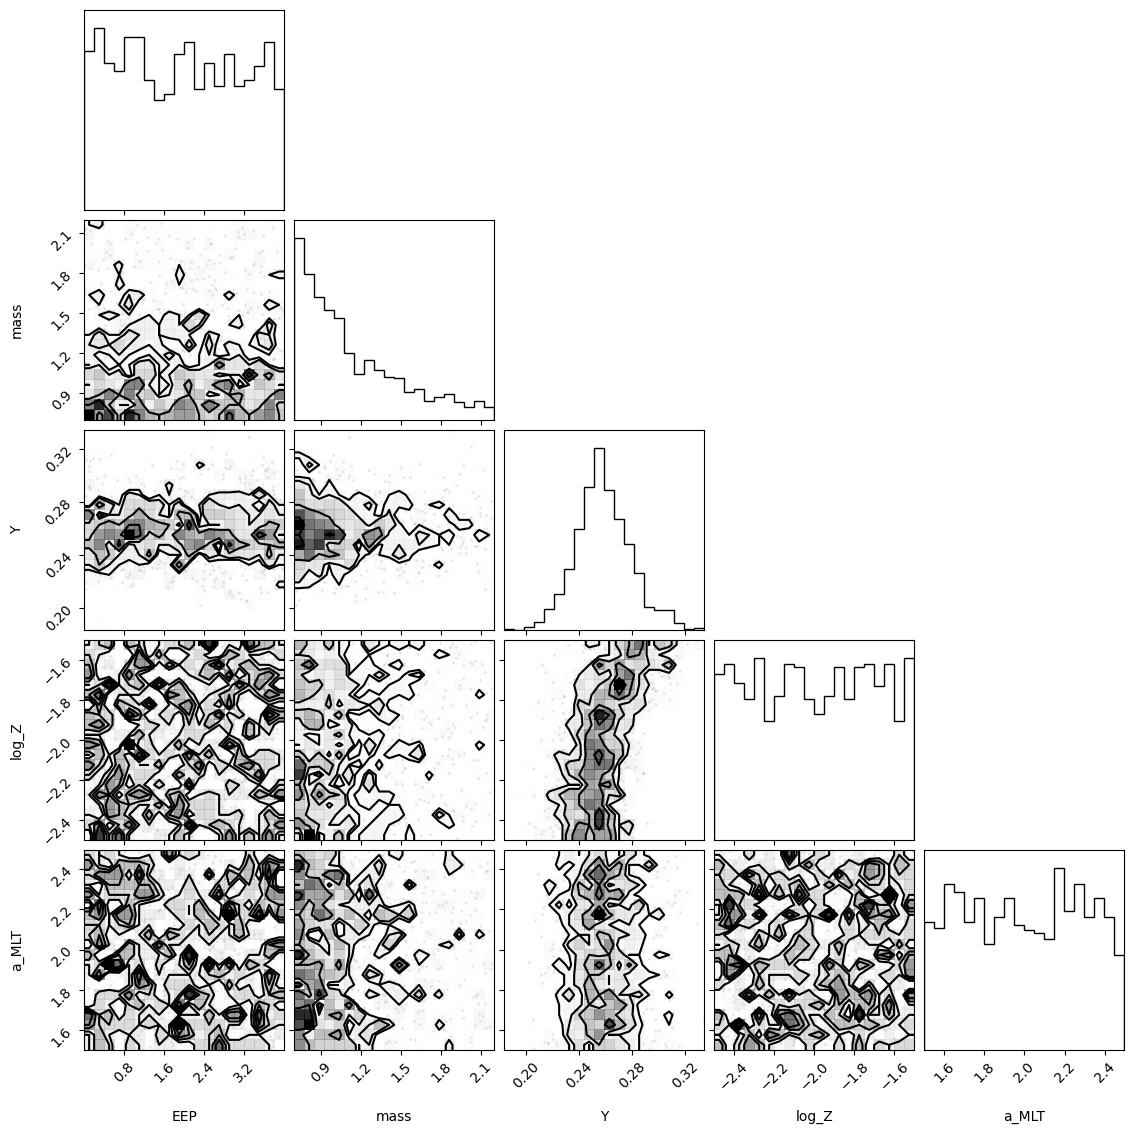

In [51]:
star = 0
var_names = ["EEP", "mass", "Y", "log_Z", "a_MLT"]
fig = corner(data, group="prior", var_names=var_names, coords={"star": star})

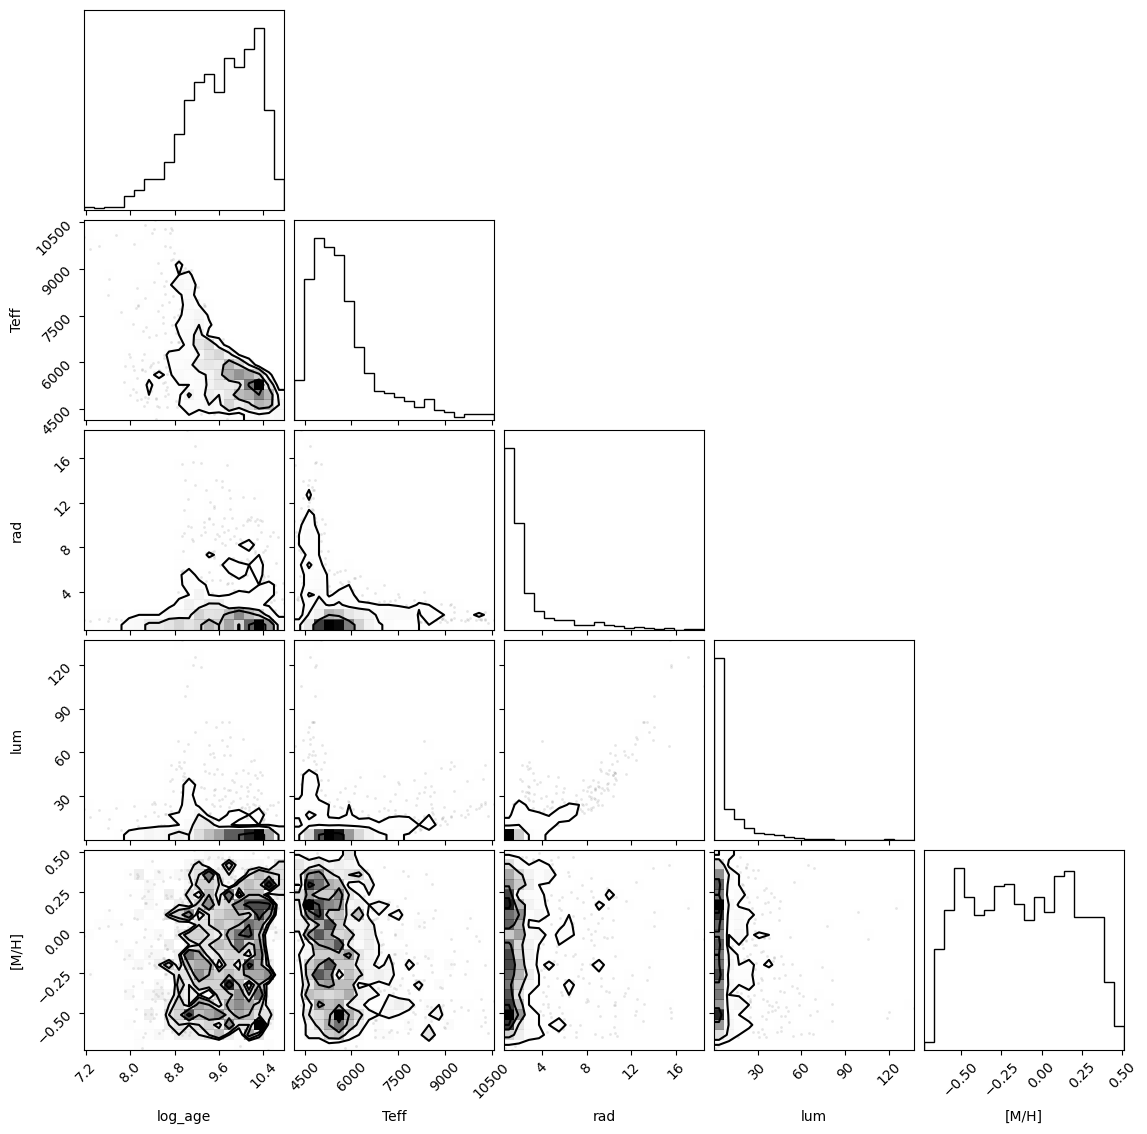

In [52]:
star = 0
var_names = ["log_age", "Teff", "rad", "lum", "[M/H]"]
fig = corner(data, group="prior", var_names=var_names, coords={"star": star})

In [53]:
nuts = NUTS(model, init_strategy=numpyro.infer.init_to_median)
mcmc = MCMC(nuts, num_warmup=1000, num_samples=1000, num_chains=10)

In [54]:
teff = true_stars["Teff"].squeeze()
lum = true_stars["lum"].squeeze()
mh = true_stars["[M/H]"].squeeze()

In [ ]:
rng, key = random.split(rng)
mcmc.run(key, num_stars, lum=lum, teff=teff, mh=mh)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [42]:
mcmc.print_summary()


                 mean       std    median      5.0%     95.0%     n_eff     r_hat
     EEP[0]      2.00      1.16      2.00      0.28      3.87  14491.44      1.00
     EEP[1]      2.00      1.16      2.01      0.26      3.86  13595.24      1.00
     EEP[2]      2.01      1.16      2.03      0.20      3.77  14421.65      1.00
     EEP[3]      2.00      1.15      2.02      0.40      3.99  14182.37      1.00
     EEP[4]      1.99      1.15      2.00      0.30      3.86  14750.69      1.00
     EEP[5]      2.00      1.16      1.99      0.03      3.63  13316.04      1.00
     EEP[6]      2.00      1.15      2.00      0.40      3.99  15658.77      1.00
     EEP[7]      2.00      1.16      2.00      0.36      3.95  13944.04      1.00
     EEP[8]      2.00      1.14      2.00      0.40      3.96  14579.02      1.00
     EEP[9]      2.00      1.16      2.00      0.40      3.99  13605.53      1.00
        Y_p      0.24      0.01      0.24      0.22      0.26  14217.35      1.00
   a_MLT[0]    

In [23]:
data += az.from_numpyro(mcmc, coords=coords, dims=dims)
data

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> prior
	> observed_data

In [25]:
rng, key = random.split(rng)
post_predictive = Predictive(model, posterior_samples=mcmc.get_samples())
post_samples = post_predictive(key, num_stars)

In [26]:
data += az.from_numpyro(posterior_predictive=post_samples, coords=coords, dims=dims)
data

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> observed_data

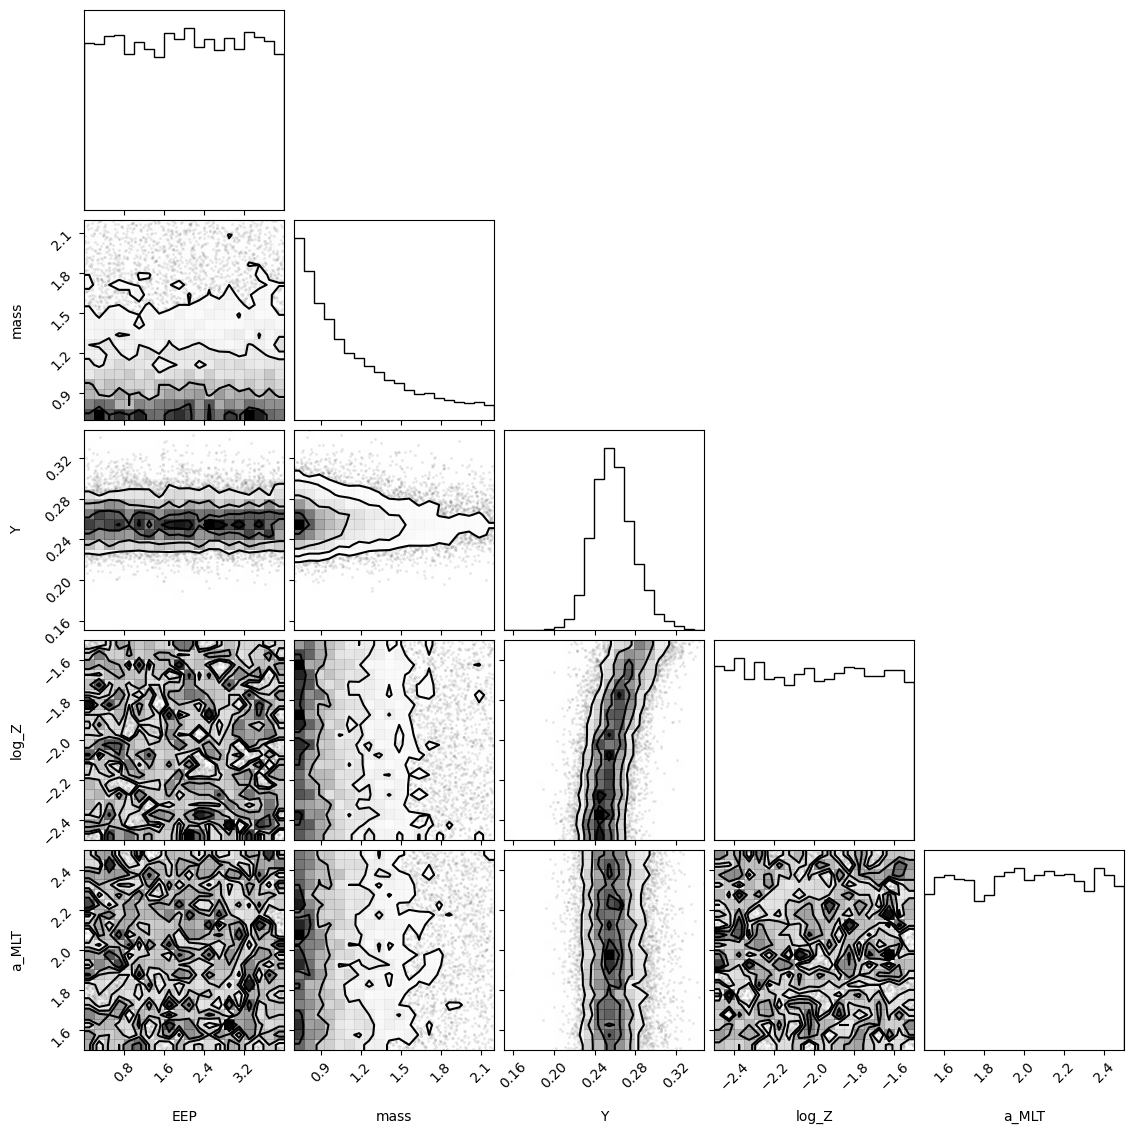

In [27]:
star = 0
var_names = ["EEP", "mass", "Y", "log_Z", "a_MLT"]
fig = corner(data, group="posterior", var_names=var_names, coords={"star": star})

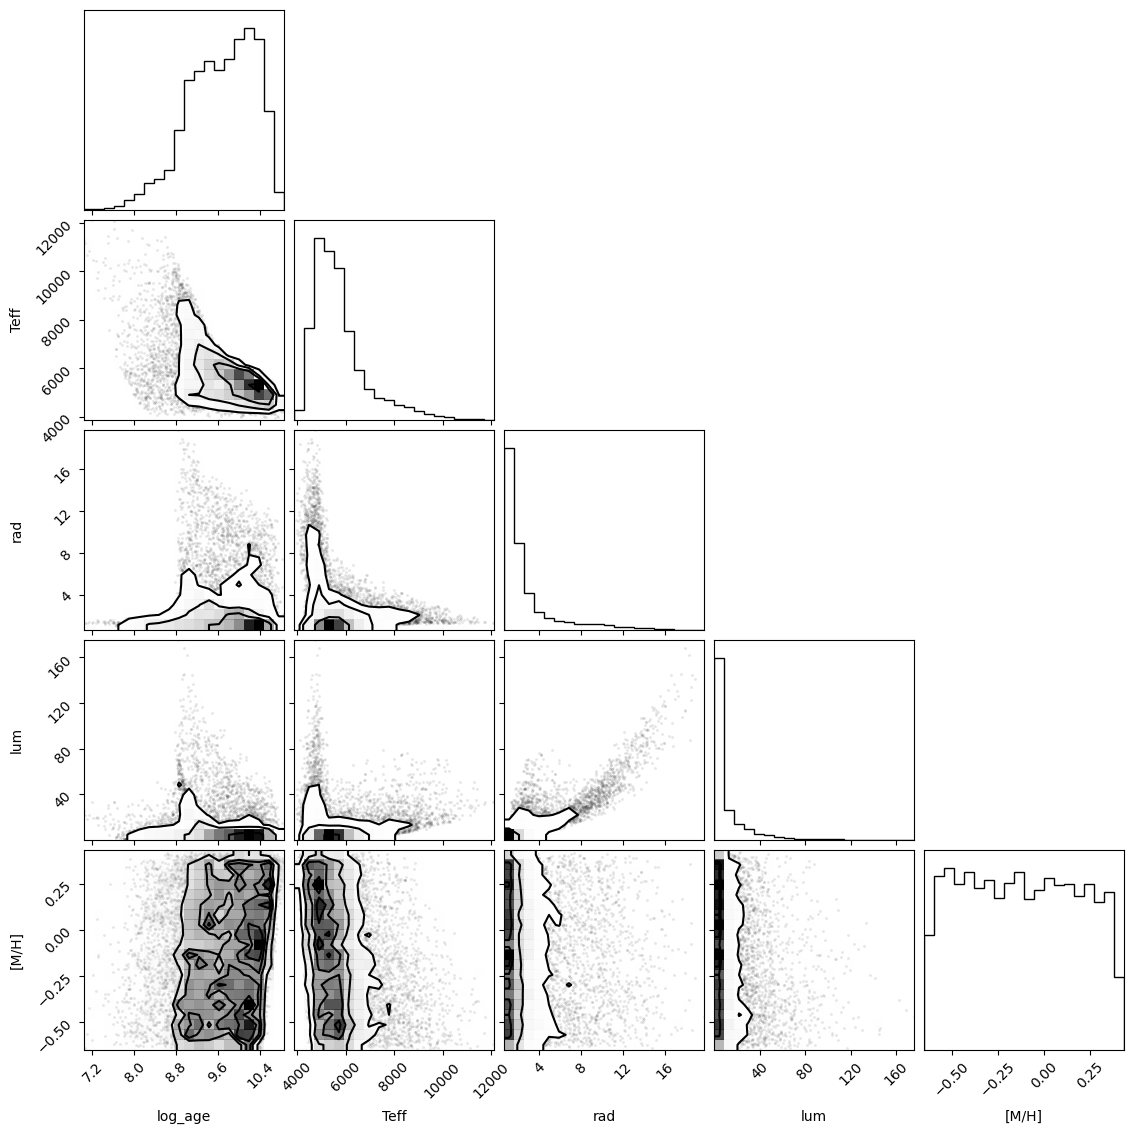

In [28]:
star = 0
var_names = ["log_age", "Teff", "rad", "lum", "[M/H]"]
fig = corner(data, group="posterior_predictive", var_names=var_names, coords={"star": star})